In [47]:
import os
import matplotlib.pyplot as plt

RESULTS_DIR = "plots"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [48]:
import numpy as np
from ev_experiments_new import phase_sweep_df_I0
from ev_plotting_new import plot_phase_plot_I0

# === parameter grids ===
X0_values = np.linspace(0.0, 1.0, 100)
I0_values = np.linspace(0.0, 1.0, 100)

phase_df = phase_sweep_df_I0(
    X0_values=X0_values,
    I0_values=I0_values,
    T=200,
    batch_size=16,
    strategy_choice_func="logit",
    tau=2.0,
    scenario_kwargs={
        "a0": 2.0,
        "beta_I": 1.0,
        "b": 1.0,
        "g_I": 0.05,
        "network_type":  "BA",
        "n_nodes": 500,
    },
)

# plot & save
heatmap_path = plot_phase_plot_I0(phase_df)
heatmap_path


'c:\\Users\\leonc\\mbd-notebooks\\Model-Based-Decisions-Code_2\\Assignment 3\\plots\\ev_phase_plot_I0.png'

In [49]:
df = phase_df.copy()
df.sort_values(["I0", "X0"], inplace=True)

tipping_points = []

for I0, group in df.groupby("I0"):
    low_mask  = group["X_final"] < 0.2
    high_mask = group["X_final"] > 0.8
    
    if high_mask.any() and low_mask.any():
        # there is a real jump from low to high
        X0_crit = group.loc[high_mask, "X0"].min()
        tipping_points.append((I0, X0_crit))

tipping_points[:10]  # (I0, X0*), first few

[(0.0, np.float64(0.5454545454545455)),
 (0.010101010101010102, np.float64(0.5151515151515152)),
 (0.020202020202020204, np.float64(0.5050505050505051)),
 (0.030303030303030304, np.float64(0.5252525252525253)),
 (0.04040404040404041, np.float64(0.5656565656565657)),
 (0.05050505050505051, np.float64(0.5252525252525253)),
 (0.06060606060606061, np.float64(0.5151515151515152)),
 (0.07070707070707072, np.float64(0.5353535353535354)),
 (0.08080808080808081, np.float64(0.5252525252525253)),
 (0.09090909090909091, np.float64(0.5656565656565657))]

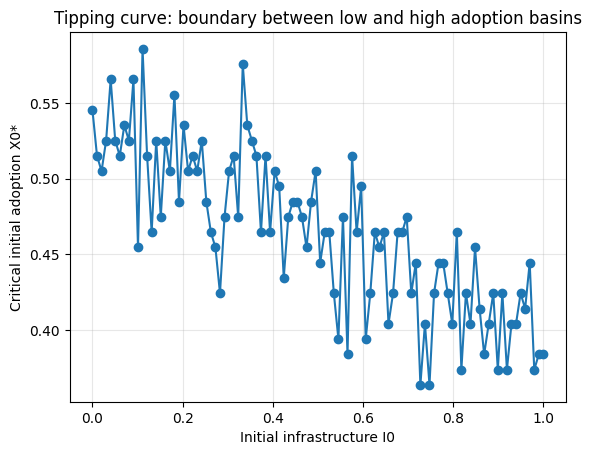

In [50]:
I0_crit, X0_crit = zip(*tipping_points)

plt.plot(I0_crit, X0_crit, "-o")
plt.xlabel("Initial infrastructure I0")
plt.ylabel("Critical initial adoption X0*")
plt.title("Tipping curve: boundary between low and high adoption basins")
plt.grid(True, alpha=0.3)
plt.show()

In [51]:
from ev_experiments_new import I0_sweep_df
from ev_plotting_new import plot_I0_sweep
import numpy as np

I0_values = np.linspace(0.0, 1.0, 100)

sweep_df = I0_sweep_df(
    X0_frac=0.3,          # fix adoption
    I0_values=I0_values,
    T=200,
    batch_size=16,
    strategy_choice_func="logit",
    tau=2.0,
    scenario_kwargs={
        "a0": 2.0,
        "beta_I": 1.0,
        "b": 1.0,
        "g_I": 0.05,
        "network_type": "BA",
        "n_nodes": 500,
    },
)

curve_path = plot_I0_sweep(sweep_df)
curve_path

'c:\\Users\\leonc\\mbd-notebooks\\Model-Based-Decisions-Code_2\\Assignment 3\\plots\\ev_I0_sweep.png'

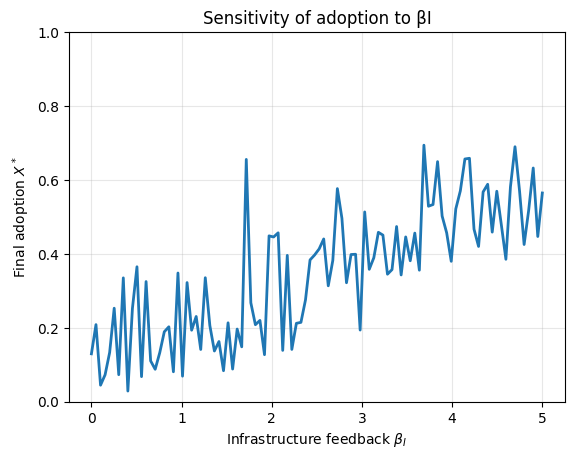

In [52]:
from ev_core_new import final_mean_adoption_vs_I0
import numpy as np
import matplotlib.pyplot as plt

beta_values = np.linspace(0.0, 5.0, 100)
X_star_means = []

X0_fixed = 0.3
I0_fixed = 0.3

for beta in beta_values:
    X_means = final_mean_adoption_vs_I0(
        X0_frac=X0_fixed,
        I0_values=[I0_fixed],
        a0=2.0,
        beta_I=beta,
        b=1.0,
        g_I=0.05,
        T=200,
        network_type="BA",
        n_nodes=500,
        p=0.05,
        m=2,
        batch_size=16,
        strategy_choice_func="logit",
        tau=3.0,
    )
    X_star_means.append(X_means[0])

plt.figure()
plt.plot(beta_values, X_star_means, lw=2)
plt.xlabel(r"Infrastructure feedback $\beta_I$")
plt.ylabel("Final adoption $X^*$")
plt.title("Sensitivity of adoption to βI")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx

from ev_core_new import EVStagHuntModel, set_initial_adopters

def simulate_one_topology(
    network_type: str,
    X0_frac: float = 0.3,
    I0: float = 0.3,
    T: int = 200,
    seed: int = 0,
    a0: float = 2.0,
    beta_I: float = 1.0,
    b: float = 1.0,
    g_I: float = 0.005,
    n_nodes: int = 500,
    p: float = 0.05,
    m: int = 2,
    strategy_choice_func: str = "logit",
    tau: float = 2.0,
):
    """
    Run one simulation on a given topology, return metrics:
    - speed of adoption (time to reach X >= 0.8)
    - final X
    - high-adoption indicator
    - cluster metrics for adopters
    """
    # build model
    model = EVStagHuntModel(
        initial_ev=0,          # we'll set adopters manually
        a0=a0,
        beta_I=beta_I,
        b=b,
        g_I=g_I,
        I0=I0,
        seed=seed,
        network_type=network_type,  # "grid", "WS", "BA", "random"
        n_nodes=n_nodes,
        p=p,
        m=m,
        collect=True,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    # set initial adopters by fraction
    set_initial_adopters(model, X0_frac, method="random", seed=seed)

    # run
    for t in range(T):
        model.step()

    # time series
    df = model.datacollector.get_model_vars_dataframe()
    X_series = df["X"].to_numpy()
    final_X = float(X_series[-1])

    # speed: first time we cross 0.8 (if ever)
    threshold = 0.8
    speed = T
    for t, x in enumerate(X_series):
        if x >= threshold:
            speed = t
            break

    # high-adoption equilibrium indicator
    high_eq = 1 if final_X >= threshold else 0

    # cluster metrics at final time
    adopters = [a.pos for a in model.schedule.agents if a.strategy == "C"]
    if len(adopters) == 0:
        largest_cluster_frac = 0.0
        n_clusters = 0
    else:
        H = model.G.subgraph(adopters).copy()
        comps = list(nx.connected_components(H))
        if len(comps) == 0:
            largest_cluster_frac = 0.0
            n_clusters = 0
        else:
            largest_size = max(len(c) for c in comps)
            largest_cluster_frac = largest_size / model.G.number_of_nodes()
            n_clusters = len(comps)

    return {
        "network_type": network_type,
        "seed": seed,
        "X0_frac": X0_frac,
        "I0": I0,
        "speed_to_0.8": speed,
        "final_X": final_X,
        "high_eq": high_eq,
        "largest_cluster_frac": largest_cluster_frac,
        "n_clusters": n_clusters,
    }

In [54]:
def sweep_topologies(
    network_types=("grid", "WS", "BA", "ER"),
    n_trials_per_topology=50,
    X0_frac=0.2,
    I0=0.1,
    T=250,
):
    rows = []
    for net in network_types:
        for seed in range(n_trials_per_topology):
            metrics = simulate_one_topology(
                network_type=net,
                X0_frac=X0_frac,
                I0=I0,
                T=T,
                seed=seed,
            )
            rows.append(metrics)
    return pd.DataFrame(rows)

In [55]:
# run the experiment
topo_df = sweep_topologies(
    network_types=("grid", "WS", "BA"),
    n_trials_per_topology=50,
    X0_frac=0.3,
    I0=0.3,
    T=200,
)

summary = topo_df.groupby("network_type").agg(
    mean_speed=("speed_to_0.8", "mean"),
    prob_high=("high_eq", "mean"),
    mean_giant_cluster=("largest_cluster_frac", "mean"),
    mean_n_clusters=("n_clusters", "mean"),
)

summary

,mean_speed,prob_high,mean_giant_cluster,mean_n_clusters
network_type,,,,
BA,156.30,0.22,0.25568,0.58
WS,4.60,1.00,1.00000,1.00
grid,1.02,1.00,1.00000,1.00


In [56]:
def tipping_sweep_by_topology(
    network_types=("grid", "WS", "BA"),
    X0_values=np.linspace(0.0, 1.0, 25),
    n_trials=30,
    I0=0.3,
    T=200,
):
    records = []
    for net in network_types:
        for X0 in X0_values:
            for seed in range(n_trials):
                metrics = simulate_one_topology(
                    network_type=net,
                    X0_frac=X0,
                    I0=I0,
                    T=T,
                    seed=seed,
                )
                records.append(metrics)
    return pd.DataFrame(records)

In [57]:
tip_df = tipping_sweep_by_topology(
    network_types=("grid", "WS", "BA"),
    X0_values=np.linspace(0.0, 1.0, 25),
    n_trials=30,
    I0=0.3,
    T=200,
)

# probability of high equilibrium vs X0 for each topology
tipping_summary = (
    tip_df
    .groupby(["network_type", "X0_frac"])
    .agg(prob_high=("high_eq", "mean"))
    .reset_index()
)

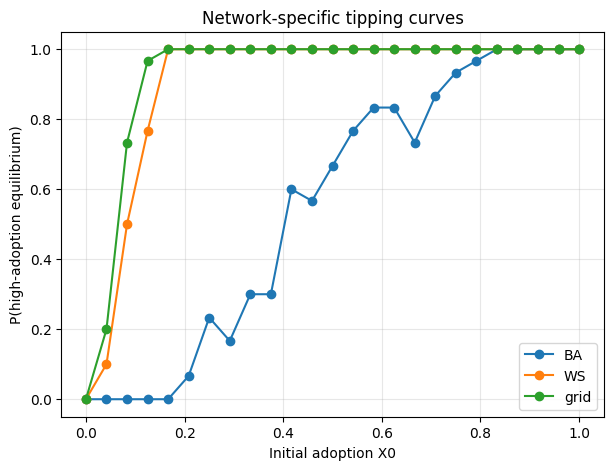

In [58]:
plt.figure(figsize=(7,5))

for net in tipping_summary["network_type"].unique():
    sub = tipping_summary[tipping_summary["network_type"] == net]
    plt.plot(sub["X0_frac"], sub["prob_high"], marker="o", label=net)

plt.xlabel("Initial adoption X0")
plt.ylabel("P(high-adoption equilibrium)")
plt.title("Network-specific tipping curves")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [59]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from ev_core_new import run_network_trial
from ev_experiments_new import run_timeseries_trial

network_types = ["grid", "WS", "BA", "random"]
T = 200
n_trials = 30
results = {}

for net in network_types:
    times_to_80 = []
    for seed in range(n_trials):
        X, I, df = run_timeseries_trial(
            T=T,
            scenario_kwargs={
                "network_type": net,
                "n_nodes": 500,
                "X0_frac": 0.3,   # same initial adoption
                "I0": 0.3,        # same infra etc.
            },
            seed=seed,
        )

        # time-to-threshold metric (see next section)
        thr = 0.8
        hit_times = [t for t, x in enumerate(X) if x >= thr]
        if hit_times:
            times_to_80.append(hit_times[0])  # first time reaching 80%

    results[net] = times_to_80

C:\Users\leonc\AppData\Local\Temp\ipykernel_2952\295821119.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cleaned.values(), labels=cleaned.keys())


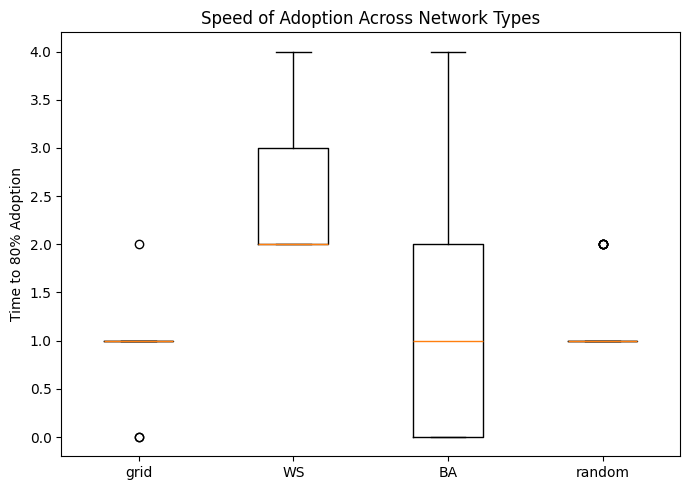

In [60]:
import matplotlib.pyplot as plt

# Filter out empty or infinite values if you used ∞ for failures
cleaned = {k: [x for x in v if x != float("inf")] for k, v in results.items()}

plt.figure(figsize=(7,5))
plt.boxplot(cleaned.values(), labels=cleaned.keys())
plt.ylabel("Time to 80% Adoption")
plt.title("Speed of Adoption Across Network Types")
plt.tight_layout()
plt.show()

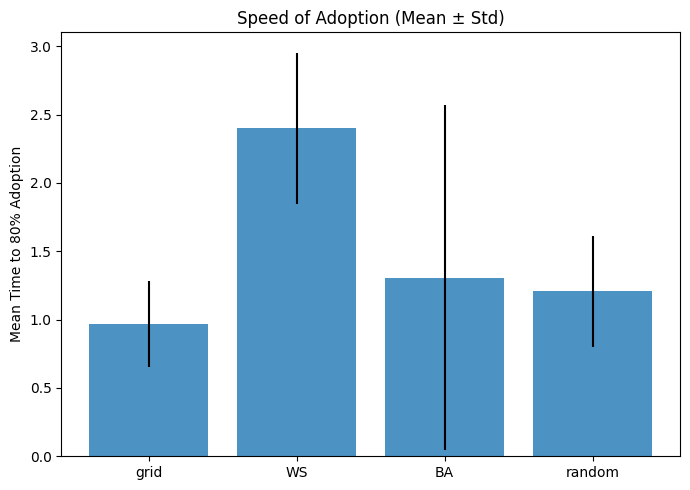

In [61]:
means = {k: np.mean(v) for k, v in cleaned.items()}
stds  = {k: np.std(v)  for k, v in cleaned.items()}

labels = list(means.keys())
x = np.arange(len(labels))

plt.figure(figsize=(7,5))
plt.bar(x, [means[k] for k in labels], yerr=[stds[k] for k in labels], alpha=0.8)
plt.xticks(x, labels)
plt.ylabel("Mean Time to 80% Adoption")
plt.title("Speed of Adoption (Mean ± Std)")
plt.tight_layout()
plt.show()